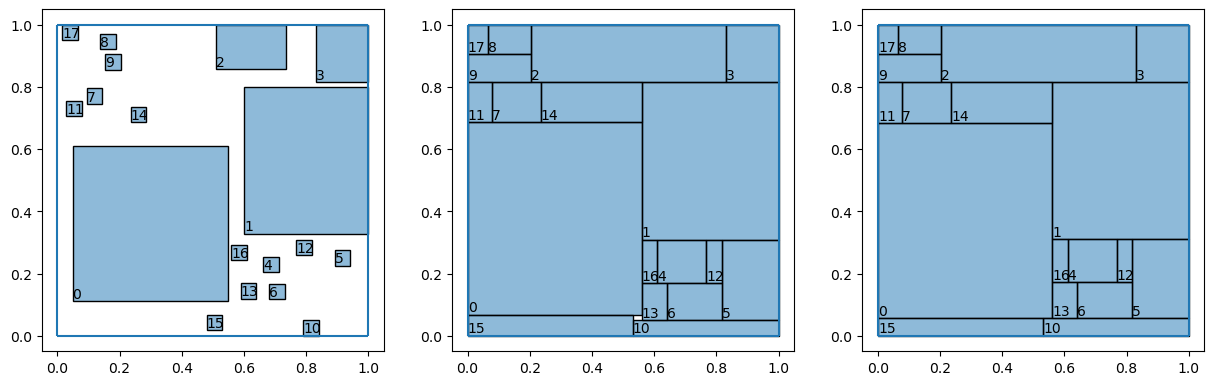

In [6]:
import numpy as np
from SquareDivision.src.rectangle_class import Rectangulation

rects = Rectangulation(config={'seed' : 1236})# 1000000000000001})#123456})
rects.execute(num=50)
rects.prepare_constraints(keep_feasible=True)
rects.close_holes()

rects.draw(disjoint=True, inflated=True, closed=True)

In [7]:
rects.report(tol=0.001)

rectangle no. 15 relatively changed by  0.022 
rectangle no.  0 relatively changed by  0.019 
rectangle no. 13 relatively changed by  0.012 
rectangle no.  6 relatively changed by  0.010 
rectangle no. 10 relatively changed by  0.008 
rectangle no.  5 relatively changed by  0.008 
rectangle no. 16 relatively changed by  0.004 
rectangle no. 11 relatively changed by  0.003 
rectangle no.  1 relatively changed by  0.003 
rectangle no.  7 relatively changed by  0.003 
rectangle no.  4 relatively changed by  0.003 
rectangle no. 14 relatively changed by  0.003 
rectangle no. 12 relatively changed by  0.003 


In [10]:
a = np.array([3,0,2,0,4,6])
order = np.argsort(a)[::-1]
a[order]

array([6, 4, 3, 2, 0, 0])

In [7]:
adotat = np.linalg.inv(np.matmul(rects.constraint.A, np.transpose(rects.constraint.A)))
l = np.matmul(adotat, -rects.constraint.A.dot(rects.x0)+rects.constraint.lb)

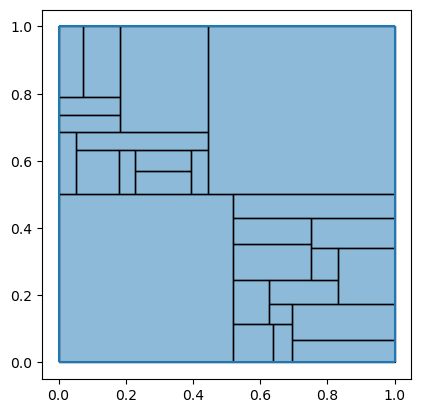

In [14]:
import matplotlib.pyplot as plt
from SquareDivision.draw.draw import draw_rectangles, rectangle_numbers
lin_sol = (rects.x0 + (rects.constraint.A.T).dot(l)).reshape(-1,4)
fig, ax = plt.subplots()
ax = draw_rectangles(ax, lin_sol)

In [12]:
import numpy as np
from SquareDivision.src.distributions import RngDistribution, SizeDistribution, linear_on_position
rects.sample_centers(RngDistribution(), rng=rects.rng, distribution='uniform', low=[0, 0], high=[1, 1], size=(5, 2))
rects.sample_widths(
    startegy=SizeDistribution(), 
    centers=rects.centers, 
    size_distribution=lambda arg : linear_on_position(arg, a=np.array([0.25, 0.0]), b=0.05))
rects.sample_heights(
    startegy=SizeDistribution(), 
    centers=rects.centers,
    size_distribution=lambda arg : linear_on_position(arg, a=np.array([0.0, 0.25]), b=0.05))

In [14]:
arr = np.c_[rects.centers, rects.widths, rects.heights]
print(arr)
print(f'centers:\n{rects.centers}')
print(f'widths:\n{rects.widths}')
print(f'heights:\n{rects.heights}')

[[0.40366138 0.32505784 0.15091534 0.13126446]
 [0.62742836 0.74815288 0.20685709 0.23703822]
 [0.68871522 0.85057967 0.2221788  0.26264492]
 [0.51017833 0.72109407 0.17754458 0.23027352]
 [0.44967745 0.34633962 0.16241936 0.13658491]]
centers:
[[0.40366138 0.32505784]
 [0.62742836 0.74815288]
 [0.68871522 0.85057967]
 [0.51017833 0.72109407]
 [0.44967745 0.34633962]]
widths:
[0.15091534 0.20685709 0.2221788  0.17754458 0.16241936]
heights:
[0.13126446 0.23703822 0.26264492 0.23027352 0.13658491]


In [4]:
from SquareDivision.src.distributions import tepui_distribution
print(rects.centers)
tepui_distribution(rects.centers, pts=np.array(
            [[0.25, 0.25],
             [0.75, 0.75],]
             )
    )

[[0.73892551 0.64887878]
 [0.38057859 0.0023377 ]
 [0.58649654 0.75154463]]


array([0.3 , 0.05, 0.3 ])

In [5]:
rects.sample_heights(
    startegy=SizeDistribution(), 
    centers=rects.centers,
    size_distribution=tepui_distribution)

In [6]:
print(f'heights:\n{rects.heights}')

heights:
[0.3  0.05 0.3 ]


#### Maybe x0 from the graph ?

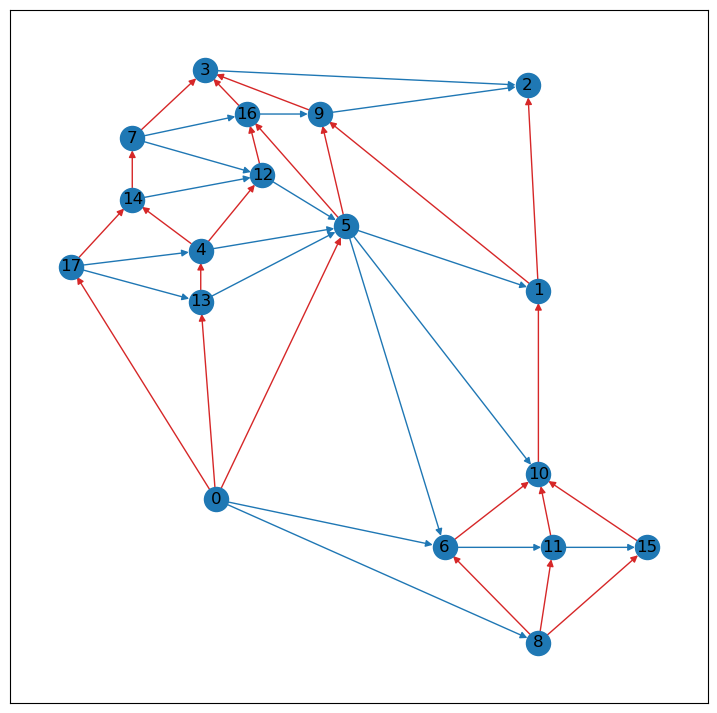

In [3]:
rects.graph_processing(rects.closed)
import networkx as nx
import matplotlib.pyplot as plt
H = nx.from_numpy_array(rects.east_neighbours, create_using=nx.DiGraph)# + rects.north_neighbours)
V = nx.from_numpy_array(rects.north_neighbours, create_using=nx.DiGraph)# + rects.north_neighbours)
attrs = { i : {'pos': tuple(row[:2] + 0.5 * row[2:4])} for i, row in enumerate(rects.clinched_rectangles)}
nx.set_node_attributes(H, attrs)
pos = nx.get_node_attributes(H,'pos')
fig, ax = plt.subplots(figsize=(9, 9))
nx.draw_networkx(H, pos=pos, ax=ax,  edge_color='tab:blue' )
nx.draw_networkx_edges(V, pos=pos, ax=ax, edge_color='tab:red')
plt.show()

In [73]:
import numpy as np
a = np.arange(80)
a = a.reshape(-1,4)
a[[5,3,7,0]] = np.arange(16).reshape(-1,4)
a

array([[12, 13, 14, 15],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [ 4,  5,  6,  7],
       [16, 17, 18, 19],
       [ 0,  1,  2,  3],
       [24, 25, 26, 27],
       [ 8,  9, 10, 11],
       [32, 33, 34, 35],
       [36, 37, 38, 39],
       [40, 41, 42, 43],
       [44, 45, 46, 47],
       [48, 49, 50, 51],
       [52, 53, 54, 55],
       [56, 57, 58, 59],
       [60, 61, 62, 63],
       [64, 65, 66, 67],
       [68, 69, 70, 71],
       [72, 73, 74, 75],
       [76, 77, 78, 79]])

#### (w,h) Distribution playground

In [3]:
import numpy as np
pts_diag = np.array(
                 [[0.25, 0.25],
                  [0.75, 0.75]])
def tepui(
        base:float=0.05,
        top:float=0.3,
        slope:float=4,
        vertex:float=1,
        pts:np.ndarray=pts_diag
):
    return lambda pt : np.minimum(top, np.maximum(base, vertex - slope * np.min(np.linalg.norm(pts - pt, axis=1))))

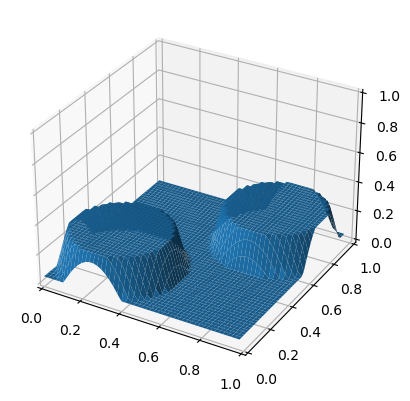

In [6]:
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

tepui_at = tepui(
        base=0.05,
        top=0.3,
        slope=5,
        vertex=1.5,
)

x = np.arange(0, 1, 0.02)
y = np.arange(0, 1, 0.02)

X, Y = np.meshgrid(x, y)
points = np.array([X,Y])

nu = np.apply_along_axis(tepui_at, 0, points)

fig = plt.figure()
ax:Axes = fig.add_subplot(projection='3d')
ax.axes.set_xlim3d(left=0, right=1) 
ax.axes.set_ylim3d(bottom=0, top=1) 
ax.axes.set_zlim3d(bottom=0, top=1) 
ax.plot_surface(X, Y, nu)
plt.show()

In [10]:
import numpy as np
x = np.arange(16).reshape(-1,4)
shape = x.shape
# y = np.ones(shape=(4,4))
# np.linalg.norm(x-y )
np.ravel_multi_index(multi_index=([0,2],[2,3],[2,0]), dims=shape) 

ValueError: parameter multi_index must be a sequence of length 2

In [2]:
import numpy as np
np.where(np.sum(rects.east_neighbours, axis=1) == 0)[0]
# for rect_num in range(shape[0]):
#         if np.sum(upper_neighbours.T[rect_num]) == 0:

array([ 1,  2,  8, 10, 15], dtype=int64)

In [9]:
import numpy as np
from numpy.random._generator import Generator

def call_experiment(distribution, rng:Generator, **kwargs):
    return rng.__getattribute__(distribution)(**kwargs)
xmin, ymin, xmax, ymax = 0, 0, 1, 1
# [xmin, ymin], [xmax, ymax], size=(2, 2)
call_experiment('uniform', rects.rng, low=[0, 0], high=[1, 1], size=(2, 2))

array([[0.95186745, 0.26756241],
       [0.69207914, 0.72522422]])